# Άσκηση 4, Βελτιστοποίηση:
Θεωρήστε την εικόνα αποχρώσεων του γκρι ‘lenna.jpg’ και τις τρεις εκδοχές της μετά από προσθήκη θορύβου ‘lenna-n1.jpg’, ‘lenna-n2.jpg’ και ‘lenna-n3.jpg’.

**Ζητούμενα:**

Α. Σχεδιάστε και εφαρμόστε κατάλληλα φίλτρα για τη βελτιστοποίηση της κάθε
τροποποιημένης εικόνας. Για όλες τις περιπτώσεις φιλτραρίσματος τυπώστε τη(βέλτιστη) φιλτραρισμένη εικόνα που προκύπτει και εξηγήστε λεπτομερώς τη
διαδικασία σχεδίασης του κάθε φίλτρου (π.χ. επιλογή φίλτρου, καθορισμός
παραμέτρων, κτλ.).

Β. Για κάθε περίπτωση φιλτραρίσματος υπολογίστε την τιμή του δείκτη ποιότητας SSIM της αποθορυβοποιημένης εικόνας (σε σχέση με την εικόνα αναφοράς, δηλαδή την
αρχική εικόνα χωρίς παρουσία θορύβου) και σχολιάστε τα αποτελέσματα.

In [5]:
%pip install numpy matplotlib scikit-image scipy opencv-python --quiet

Note: you may need to restart the kernel to use updated packages.


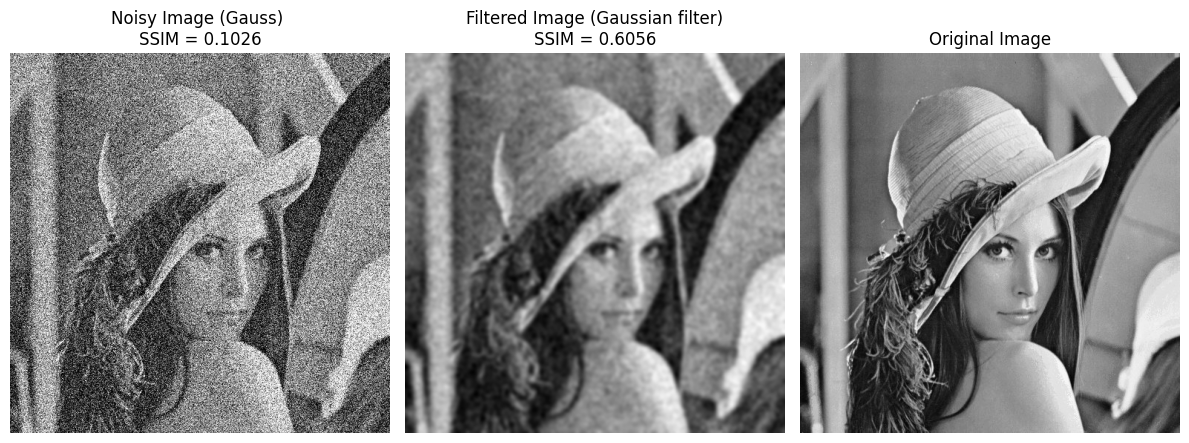

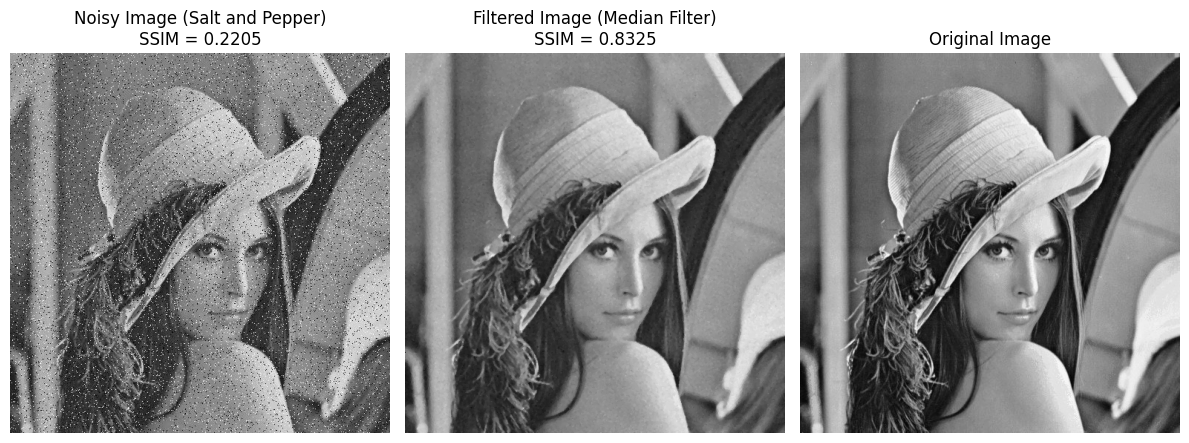

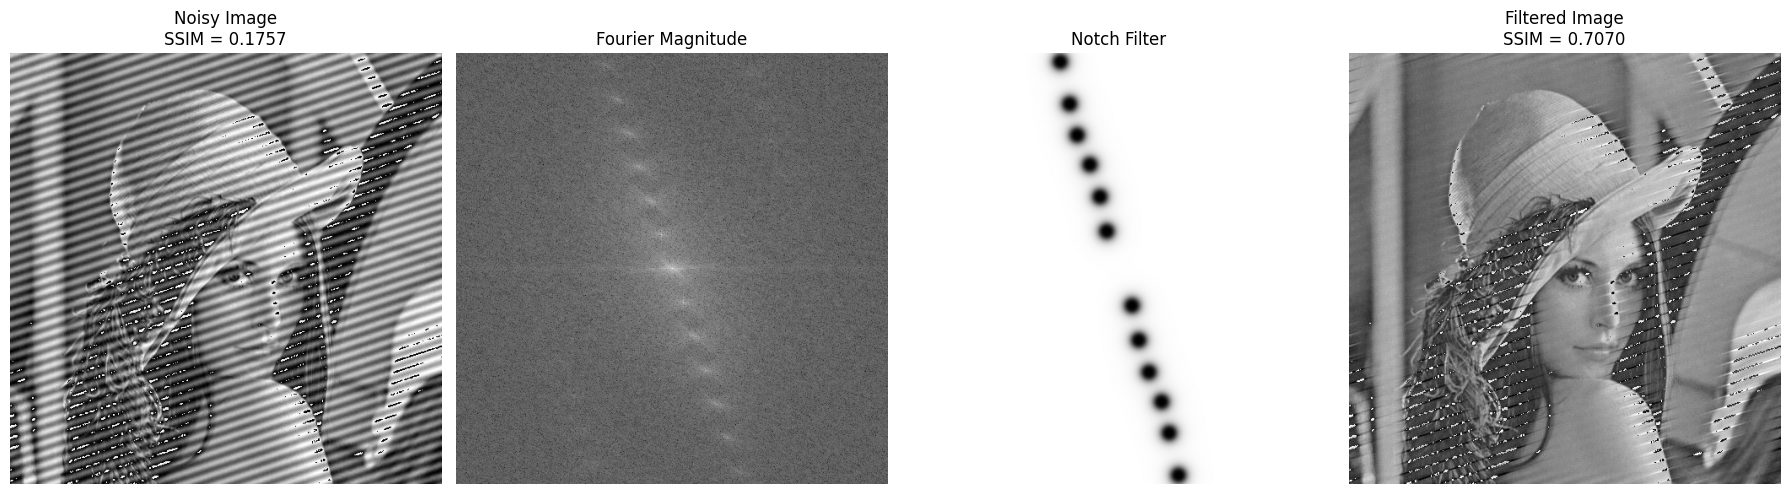

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim

lenna = ski.io.imread('https://github.com/KaratziasK/DIP-Images/blob/main/images-project-1/lenna.jpg?raw=true')
lenna_n1 = ski.io.imread('https://github.com/KaratziasK/DIP-Images/blob/main/images-project-1/lenna-n1.jpg?raw=true')
lenna_n2 = ski.io.imread('https://github.com/KaratziasK/DIP-Images/blob/main/images-project-1/lenna-n2.jpg?raw=true')
lenna_n3 = ski.io.imread('https://github.com/KaratziasK/DIP-Images/blob/main/images-project-1/lenna-n3.jpg?raw=true')

# Gaussian filter
filtered_image = gaussian_filter(lenna_n1, sigma=2.657) # 2.657 βρέθηκε με δοκιμές και συγκρίσεις του SSIM

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ssim_n1_initial = ssim(lenna, lenna_n1, data_range=filtered_image.max() - filtered_image.min())
ssim_n1_filtered = ssim(lenna, filtered_image, data_range=filtered_image.max() - filtered_image.min())

ax[0].imshow(lenna_n1, cmap='gray')
ax[0].set_title(f'Noisy Image (Gauss) \nSSIM = {ssim_n1_initial:.4f}')
ax[0].axis('off')

ax[1].imshow(filtered_image, cmap='gray')
ax[1].set_title(f'Filtered Image (Gaussian filter)\nSSIM = {ssim_n1_filtered:.4f}')
ax[1].axis('off')

ax[2].imshow(lenna, cmap='gray')
ax[2].set_title('Original Image')
ax[2].axis('off')

plt.tight_layout()
plt.show()

# Median filter (salt-and-pepper noise)
filtered_image_lenna_n2 = median_filter(lenna_n2, size=3)

ssim_n2_initial = ssim(lenna, lenna_n2, data_range=filtered_image_lenna_n2.max() - filtered_image_lenna_n2.min())
ssim_n2_filtered = ssim(lenna, filtered_image_lenna_n2, data_range=filtered_image_lenna_n2.max() - filtered_image_lenna_n2.min())

fig2, ax2 = plt.subplots(1, 3, figsize=(12, 6))

ax2[0].imshow(lenna_n2, cmap='gray')
ax2[0].set_title(f'Noisy Image (Salt and Pepper)\nSSIM = {ssim_n2_initial:.4f}')
ax2[0].axis('off')

ax2[1].imshow(filtered_image_lenna_n2, cmap='gray')
ax2[1].set_title(f'Filtered Image (Median Filter)\nSSIM = {ssim_n2_filtered:.4f}')
ax2[1].axis('off')

ax2[2].imshow(lenna, cmap='gray')
ax2[2].set_title('Original Image')
ax2[2].axis('off')

plt.tight_layout()
plt.show()

# Μετασχηματισμός Fourier
f = np.fft.fft2(lenna_n3)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift) + 1)

# Butterworth Notch Filter
def butterworth_notch_filter(shape, D0, order, centers):
    M, N = shape
    U, V = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
    H = np.ones((M, N))
    for u_k, v_k in centers:
        D1 = np.sqrt((U - u_k)**2 + (V - v_k)**2)
        D2 = np.sqrt((U + u_k)**2 + (V + v_k)**2)
        H *= 1 / (1 + (D0 / (D1 + 1e-6))**(2 * order))
        H *= 1 / (1 + (D0 / (D2 + 1e-6))**(2 * order))
    return H

# Σημεία θορύβου στο φάσμα
notch_centers =  [(15, 44), (23, 85), (35, 123), (50, 158), (59, 195), (70, 245)]

# Εφαρμογή του φίλτρου
H = butterworth_notch_filter(lenna_n3.shape, D0=10, order=2, centers=notch_centers)
filtered_fshift = fshift * H

# Επαναφορά εικόνας
f_ishift = np.fft.ifftshift(filtered_fshift)
img_filtered = np.fft.ifft2(f_ishift)
img_filtered = np.abs(img_filtered)
img_filtered = np.uint8(np.clip(img_filtered, 0, 255))

# Υπολογισμός SSIM
ssim_n3_initial = ssim(lenna, lenna_n3, data_range=lenna_n3.max() - lenna_n3.min())
ssim_n3_filtered = ssim(lenna, img_filtered, data_range=img_filtered.max() - img_filtered.min())

fig3, ax3 = plt.subplots(1, 4, figsize=(18, 6))

ax3[0].imshow(lenna_n3, cmap='gray')
ax3[0].set_title(f"Noisy Image\nSSIM = {ssim_n3_initial:.4f}")
ax3[0].axis('off')

ax3[1].imshow(magnitude_spectrum, cmap='gray')
ax3[1].set_title("Fourier Magnitude")
ax3[1].axis('off')

ax3[2].imshow(H, cmap='gray')
ax3[2].set_title("Notch Filter")
ax3[2].axis('off')

ax3[3].imshow(img_filtered, cmap='gray')
ax3[3].set_title(f"Filtered Image\nSSIM = {ssim_n3_filtered:.4f}")
ax3[3].axis('off')

plt.tight_layout()
plt.show()



---
# Σχόλια Αποτελέσματος:

**lenna-n1.jpg**

Χρησιμοποιήθηκε Gaussian φίλτρο.

Παράμετρος σ (sigma): Επιλέχθηκε 2.657 μετά από δοκιμές, ώστε να μεγιστοποιηθεί ο δείκτης SSIM. Αρχικό SSIM χαμηλό λόγω θορύβου. Μετά το Gaussian φίλτρο,  βελτιώθηκε.

**lenna-n2.jpg**

Χρησιμοποιήθηκε median filter γιατί ο θόρυβος είναι ξεκάθαρα salt-and-pepper.

Μέγεθος πυρήνα: 3x3, ώστε να αφαιρεί τον θόρυβο χωρίς να καταστρέφει την εικόνα (θάμπομα με μεγαλύτερο πυρήνα όπως 5x5).

Το median filter αποδίδει εξαιρετικά καλά, με SSIM που δείχνει μεγάλη αποκατάσταση.


**lenna-n3.jpg**

Χρησιμοποιήθηκε Butterworth Notch φίλτρο στο πεδίο της συχνότητας για αφαίρεση στοχευμένων συχνοτήτων. 
Ο θόρυβος που περιέχει η εικόνα είναι περιοδικός και είναι εμφανή στο φάσμα Fourier. Για τον εντοπισμό την απομάκρυνσή του, επιλέχθηκαν τα κατάλληλα σημεία (notch centers) στο φάσμα βάσει των λαμπερών περιοχών εκτός κέντρου.
Το φίλτρο σχεδιάστηκε με τάξη (order) 2 και D0=10 ώστε να επιτυγχάνεται αποθορυβοποίηση χωρίς σημαντική απώλεια πληροφορίας.
Μετά την εφαρμογή του notch filter, ο δείκτης SSIM αυξήθηκε σημαντικά, δείχνοντας βελτίωση στην ποιότητα της εικόνας.